In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [2]:
tf.__version__

'2.3.0'

## Dataset -- MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)


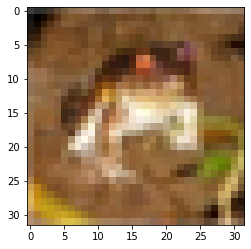

In [5]:
plt.imshow(x_train[0])
plt.show()

In [6]:
x_train[0].shape

(32, 32, 3)

In [7]:
y_train[0]

array([6], dtype=uint8)

In [8]:
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (50000, 1)
y_test shape:  (10000, 1)


In [9]:
print(y_train[:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


[0 1 2 3 4 5 6 7 8 9]
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


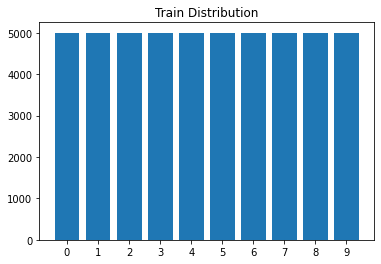

In [10]:
label, counts = np.unique(y_train, return_counts=True)
print(label)
print(counts)

plt.bar(label, counts, tick_label=label)
plt.title("Train Distribution")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                               test_size=0.2,
                               random_state=2,
                               stratify=y_train)

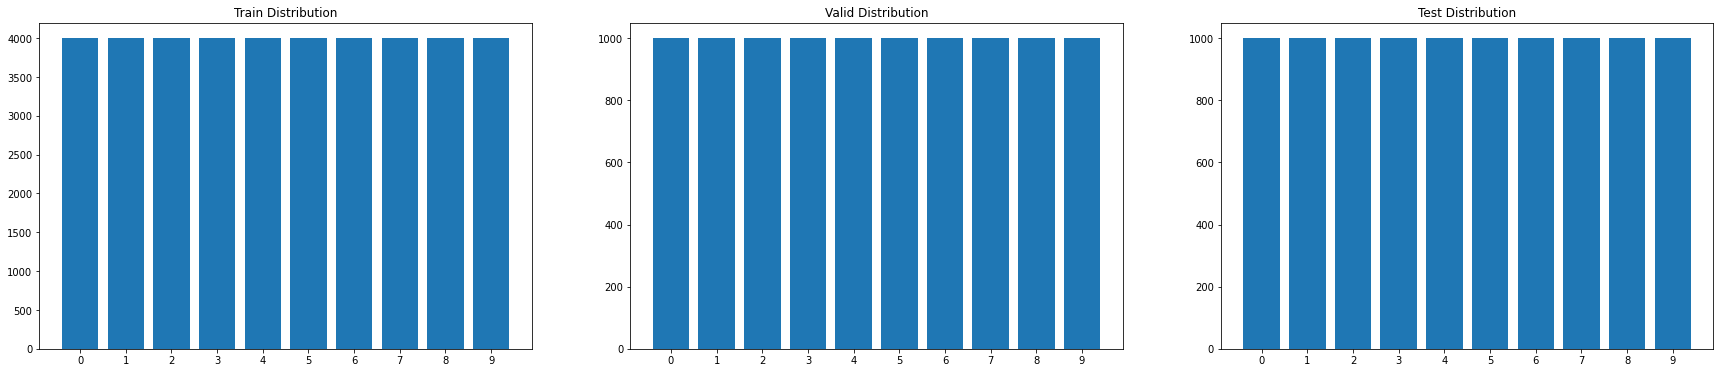

In [13]:
data_list = [y_train, y_valid, y_test]
data_types = ["Train", "Valid", "Test"]

plt.figure(figsize=(30, 6))
for i in range(3):
  label, counts = np.unique(data_list[i], return_counts=True)

  plt.subplot(1, 3, i+1)
  plt.bar(label, counts, tick_label=label)
  plt.title(data_types[i]+" Distribution")
plt.show()

## Data Preprocessing

In [14]:
print("x_train type: ", x_train.dtype)
print("x_train max: ", x_train.max())
print("x_train min: ", x_train.min())

x_train type:  uint8
x_train max:  255
x_train min:  0


In [15]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [16]:
def my_preprocess(x_data):
  pre_data=[]
  for img in x_data:
    new = preprocess_input(img[np.newaxis, ...])
    pre_data.append(new[0])
  return np.array(pre_data)

#### min_max normalization

In [17]:
x_train = my_preprocess(x_train.astype("float32"))
x_valid = my_preprocess(x_valid.astype("float32"))
x_test = my_preprocess(x_test.astype("float32"))

In [18]:
print("x_train type: ", x_train.dtype)
print("x_train max: ", x_train.max())
print("x_train min: ", x_train.min())

x_train type:  float32
x_train max:  151.061
x_train min:  -123.68


#### Category -- One-Hot Encoding

In [19]:
from tensorflow.keras.utils import to_categorical

In [20]:
y_train_one = to_categorical(y_train)
y_valid_one = to_categorical(y_valid)
y_test_one = to_categorical(y_test)

In [21]:
print("y_train type: ", y_train.dtype)
print("y_train shape: ", y_train.shape)
print("preprocessing".center(30, "-"))
print("y_train_one type: ", y_train_one.dtype)
print("y_train_one shape: ", y_train_one.shape)

y_train type:  uint8
y_train shape:  (40000, 1)
--------preprocessing---------
y_train_one type:  float32
y_train_one shape:  (40000, 10)


In [22]:
y_train[:3]

array([[2],
       [2],
       [8]], dtype=uint8)

In [23]:
y_train_one[:3]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

## Modeling

In [24]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [25]:
x_train[0].shape

(32, 32, 3)

In [26]:
num_classes = y_train_one[0].shape[0]
num_classes

10

In [27]:
pre_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)

x = layers.Flatten()(pre_model.output)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)


model = Model(inputs=pre_model.inputs, outputs=outputs)

In [28]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

In [29]:
model_weight = model.variables
# model_weight = model.get_weights()

In [30]:
# model_weight

In [31]:
# model_weight[0].shape

In [32]:
from tensorflow.keras import callbacks

In [33]:
model_dir = './model-logs'
if not os.path.exists(model_dir):
  os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                      monitor='val_accuracy',
                      save_best_only=True)

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=3,
                    verbose=1)


callbacks_list = [model_mckp, earlystop]

In [34]:
lr = 0.00001
optimizer = optimizers.Adam(lr)
model.compile(loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=['accuracy'])

In [35]:
# pre_model.trainable = False
# model.summary()

pre_model.trainable = True
for each_layer in pre_model.layers[:-5]:
    each_layer.trainable = False

In [36]:
num_epoch = 10
batch_size = 64
history = model.fit(x_train, y_train_one,
            batch_size=batch_size,
            epochs=num_epoch,
            validation_data=(x_valid, y_valid_one),
            callbacks=callbacks_list
            )

Epoch 1/10
625/625 [==============================] - 50s 80ms/step - loss: 1.8481 - accuracy: 0.4606 - val_loss: 1.0163 - val_accuracy: 0.6673
Epoch 2/10
625/625 [==============================] - 49s 79ms/step - loss: 0.8160 - accuracy: 0.7245 - val_loss: 0.7625 - val_accuracy: 0.7437
Epoch 3/10
625/625 [==============================] - 49s 79ms/step - loss: 0.6396 - accuracy: 0.7828 - val_loss: 0.6725 - val_accuracy: 0.7726
Epoch 4/10
625/625 [==============================] - 49s 79ms/step - loss: 0.5386 - accuracy: 0.8145 - val_loss: 0.6296 - val_accuracy: 0.7893
Epoch 5/10
625/625 [==============================] - 49s 79ms/step - loss: 0.4534 - accuracy: 0.8440 - val_loss: 0.5892 - val_accuracy: 0.7997
Epoch 6/10
625/625 [==============================] - 50s 79ms/step - loss: 0.3797 - accuracy: 0.8691 - val_loss: 0.5643 - val_accuracy: 0.8113
Epoch 7/10
625/625 [==============================] - 49s 79ms/step - loss: 0.3132 - accuracy: 0.8917 - val_loss: 0.5734 - val_accuracy:

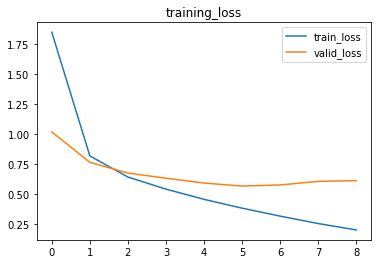

In [41]:
num_epoch = len(history.history['loss']) 
plt.plot(np.arange(num_epoch), history.history['loss'], label="train_loss")
plt.plot(np.arange(num_epoch), history.history['val_loss'], label="valid_loss")
plt.legend(loc='best')
plt.title('training_loss')
plt.show()

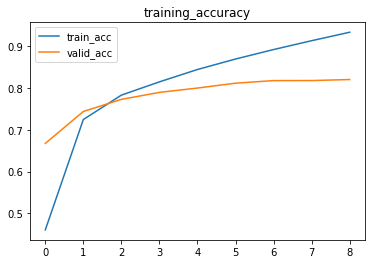

In [42]:
plt.plot(np.arange(num_epoch), history.history['accuracy'], label="train_acc")
plt.plot(np.arange(num_epoch), history.history['val_accuracy'], label="valid_acc")
plt.legend(loc='best')
plt.title('training_accuracy')
plt.show()

In [43]:
model.save("model_test.h5")

In [44]:
model = load_model("model_test.h5")

## Prediction

In [45]:
y_test_predprob = model.predict(x_test)
print(y_test_predprob[:3])

[[2.85992485e-07 3.33302125e-07 2.82203371e-04 8.42787027e-01
  7.85467780e-09 1.56666905e-01 2.47543067e-04 3.89308025e-06
  7.28758607e-07 1.11689615e-05]
 [6.84357531e-07 6.55567856e-04 2.35629827e-09 3.34248844e-11
  8.86839402e-08 3.66641309e-12 6.34443751e-08 3.05938775e-05
  9.99270499e-01 4.25303078e-05]
 [8.59109787e-05 4.94412333e-03 1.14769499e-07 8.67747385e-09
  1.23121538e-06 2.50175797e-10 1.06795130e-06 3.79896937e-06
  9.94338810e-01 6.24953129e-04]]


In [46]:
y_test_predprob.shape

(10000, 10)

In [47]:
y_test_predprob.shape

(10000, 10)

In [48]:
y_test_pred = y_test_predprob.argmax(-1)
print("y_test_pred shape: ", y_test_pred.shape)
print(y_test_pred[:3])

y_test_pred shape:  (10000,)
[3 8 8]


In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [50]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")
print("confusion matrix: \n", confusion_matrix(y_test, y_test_pred))

accuracy_score: 0.817
confusion matrix: 
 [[853  20  35   8   9   0   4   6  46  19]
 [  7 939   2   1   2   2   3   1  16  27]
 [ 37   2 811  26  46  21  36   3  14   4]
 [ 17   6  69 590  57 164  44  22  16  15]
 [ 15   4  81  23 800  14  19  22  17   5]
 [ 10   1  58 118  45 719  16  24   3   6]
 [  7   4  49  28  26  14 859   2  11   0]
 [  9   5  22  27  77  44   3 797   5  11]
 [ 32  19   4   5   0   1   0   0 923  16]
 [ 17  81   2   5   2   0   1   3  13 876]]


In [51]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


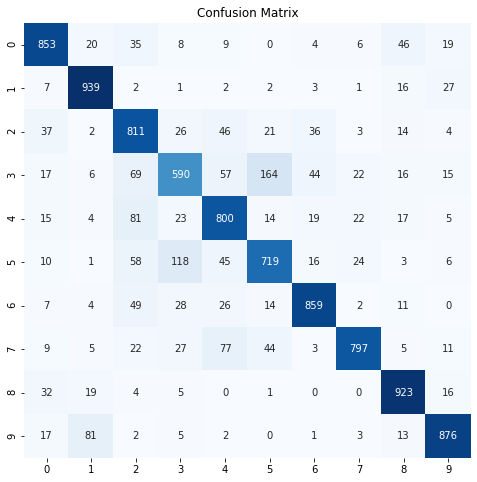

In [52]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
      cmap="Blues", annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.show()